# Neural Network Experiments

In [143]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
conn = sqlite3.connect('/Users/eerichmo/Documents/fires.sqlite')
cur = conn.cursor()

df_no_fire = pd.read_sql_query("""
select
	weather_geo.long,
	weather_geo.lat,
	weather_geo.month,
	weather_geo.date,
	weather_geo.precipitation,
	weather_geo.pressure,
	weather_geo.humidity_2m,
	weather_geo.temp_2m,
	weather_geo.temp_dew_point_2m,
	weather_geo.temp_wet_bulb_2m,
	weather_geo.temp_max_2m,
	weather_geo.temp_min_2m,
	weather_geo.temp_range_2m,
	weather_geo.temp_0m,
	weather_geo.wind_10m,
	weather_geo.wind_max_10m,
	weather_geo.wind_min_10m,
	weather_geo.wind_range_10m,
	weather_geo.wind_50m,
	weather_geo.wind_max_50m,
	weather_geo.wind_min_50m,
	weather_geo.wind_range_50m,
	weather_geo.drought_score,
	soil.elevation,
	soil.slope_005,
	soil.slope_005_02,
	soil.slope_02_05,
	soil.slope_05_10,
	soil.slope_10_15,
	soil.slope_15_30,
	soil.slope_30_45,
	soil.slope_45,
	soil.aspect_north,
	soil.aspect_east,
	soil.aspect_south,
	soil.aspect_west,
	soil.aspect_unknown,
	soil.water_land,
	soil.barren_land,
	soil.urban_land,
	soil.grass_land,
	soil.forest_land,
	soil.partial_cultivated_land,
	soil.irrigated_land,
	soil.cultivated_land,
	soil.nutrient,
	soil.nutrient_retention,
	soil.rooting,
	soil.oxygen,
	soil.excess_salts,
	soil.toxicity,
	soil.workablity,
	0 as prior_fire_0_1_year,
	0 as prior_fire_1_2_year,
	0 as prior_fire_2_3_year,
	0 as prior_fire_3_4_year,
	0 as prior_fire_4_5_year,
  '' as fire_size_class
from weather_geo_rand as weather_geo
inner join soil
  on soil.fips = weather_geo.fips
""", conn)

conn.close()

df_no_fire['date'] = df_no_fire['date'].astype('datetime64[ns]')

df_no_fire.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
long,17000.0,-119.605347,2.501498,-124.30,-121.500000,-120.000000,-117.500000,-114.200000
lat,17000.0,37.238024,2.565633,32.60,35.100000,36.900000,39.400000,42.000000
month,17000.0,6.522765,3.461054,1.00,4.000000,7.000000,10.000000,12.000000
precipitation,17000.0,1.329575,4.933209,0.00,0.000000,0.000000,0.190000,101.420000
pressure,17000.0,92.108725,6.519051,72.73,87.980000,92.885000,97.390000,102.460000
humidity_2m,17000.0,5.302655,2.099914,0.61,3.720000,5.130000,6.650000,17.090000
temp_2m,17000.0,14.613802,9.011134,-17.32,8.310000,14.200000,21.112500,40.470000
temp_dew_point_2m,17000.0,2.255359,6.270087,-20.99,-2.050000,2.690000,6.880000,22.090000
temp_wet_bulb_2m,17000.0,8.434572,6.473949,-17.67,4.120000,8.830000,13.070000,27.280000
temp_max_2m,17000.0,21.892536,10.492127,-9.91,14.170000,21.505000,30.070000,47.930000


In [65]:
conn = sqlite3.connect('/Users/eerichmo/Documents/fires.sqlite')
cur = conn.cursor()

df_yes_fire = pd.read_sql_query("""
select
	weather_geo.long,
	weather_geo.lat,
	weather_geo.month,
	weather_geo.date,
	weather_geo.precipitation,
	weather_geo.pressure,
	weather_geo.humidity_2m,
	weather_geo.temp_2m,
	weather_geo.temp_dew_point_2m,
	weather_geo.temp_wet_bulb_2m,
	weather_geo.temp_max_2m,
	weather_geo.temp_min_2m,
	weather_geo.temp_range_2m,
	weather_geo.temp_0m,
	weather_geo.wind_10m,
	weather_geo.wind_max_10m,
	weather_geo.wind_min_10m,
	weather_geo.wind_range_10m,
	weather_geo.wind_50m,
	weather_geo.wind_max_50m,
	weather_geo.wind_min_50m,
	weather_geo.wind_range_50m,
	weather_geo.drought_score,
	soil.elevation,
	soil.slope_005,
	soil.slope_005_02,
	soil.slope_02_05,
	soil.slope_05_10,
	soil.slope_10_15,
	soil.slope_15_30,
	soil.slope_30_45,
	soil.slope_45,
	soil.aspect_north,
	soil.aspect_east,
	soil.aspect_south,
	soil.aspect_west,
	soil.aspect_unknown,
	soil.water_land,
	soil.barren_land,
	soil.urban_land,
	soil.grass_land,
	soil.forest_land,
	soil.partial_cultivated_land,
	soil.irrigated_land,
	soil.cultivated_land,
	soil.nutrient,
	soil.nutrient_retention,
	soil.rooting,
	soil.oxygen,
	soil.excess_salts,
	soil.toxicity,
	soil.workablity,
	fires_rollup.prior_fire_0_1_year,
	fires_rollup.prior_fire_1_2_year,
	fires_rollup.prior_fire_2_3_year,
	fires_rollup.prior_fire_3_4_year,
	fires_rollup.prior_fire_4_5_year,
  fires_rollup.fire_size_class
from weather_geo
inner join soil
  on soil.fips = weather_geo.fips
inner join fires_rollup
  on fires_rollup.date = weather_geo.date
  and fires_rollup.long = weather_geo.long
  and fires_rollup.lat = weather_geo.lat
	and fires_rollup.cause in ('Other causes', 'Natural', 'Power', 'Recreation')
""", conn)

conn.close()

df_yes_fire['date'] = df_yes_fire['date'].astype('datetime64[ns]')

df_yes_fire.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
long,16597.0,-120.342562,2.088646,-124.0000,-122.000000,-120.500000,-119.000000,-114.500000
lat,16597.0,38.258239,2.568074,33.0000,36.500000,38.500000,40.500000,42.000000
month,16597.0,7.347352,1.901473,1.0000,6.000000,7.000000,9.000000,12.000000
precipitation,16597.0,0.529965,2.303736,0.0000,0.000000,0.010000,0.230000,109.020000
pressure,16597.0,88.953271,6.699017,73.1700,84.450000,89.480000,94.030000,102.050000
humidity_2m,16597.0,6.291352,2.142371,0.6700,4.700000,6.160000,7.690000,16.720000
temp_2m,16597.0,19.974299,6.490260,-10.8700,16.010000,20.210000,24.360000,38.510000
temp_dew_point_2m,16597.0,4.369075,5.534988,-20.5300,0.800000,4.900000,8.380000,20.930000
temp_wet_bulb_2m,16597.0,12.171678,4.984065,-12.2000,9.230000,12.650000,15.340000,26.800000
temp_max_2m,16597.0,28.284669,7.349470,-7.2100,23.730000,28.930000,33.590000,47.050000


In [239]:
print(f'Classes of NO fire: {len(df_no_fire):,} and YES fire: {len(df_yes_fire):,}')

df_fires = pd.concat([df_no_fire, df_yes_fire], axis=0)

df_fires['has_fire'] = df_fires.fire_size_class > ''

df_fires_numeric = df_fires.drop(['date', 'fire_size_class', 'has_fire'], axis=1)

df_fires_encoded = pd.get_dummies(df_fires_numeric, columns=['month'])

scaler = StandardScaler()
scaler.fit(df_fires_encoded)

X = scaler.transform(df_fires_encoded)
y = df_fires.has_fire.numpy()

num_fires = (df_fires.has_fire == True).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie ~balanced)')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Classes of NO fire: 17,000 and YES fire: 16,597
16597 fires out of 33597 data points
No fires 51.0% of the time (ie ~balanced)


## PyTorch

In [411]:
from torch.utils.data import TensorDataset
features = torch.from_numpy(X).float()
labels = torch.from_numpy(y.to_numpy()).long()
ds = TensorDataset(features, labels)

In [412]:
from torch.utils.data import random_split

data_pt_70 = round(num_data_pt * .7)
train_ds, test_ds = random_split(ds, [data_pt_70, num_data_pt - data_pt_70])
len(train_ds), len(test_ds)

(23518, 10079)

In [413]:
from torch.utils.data import DataLoader

batch_size = 200
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size)

In [414]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [415]:
def evaluate(model, valation_dl):
    outputs = [model.validation_step(batch) for batch in valation_dl]
    return model.validation_epoch_end(outputs)

In [466]:
class LogisticModel(nn.Module):
    def __init__(self, feature_count, label_count):
        super().__init__()
        self.linear = nn.Linear(feature_count, label_count)

    def forward(self, xb):
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        features, labels = batch 
        out = self(features)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        features, labels = batch 
        out = self(features)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return { 'loss': loss, 'accuracy': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return { 'loss': epoch_loss.item(), 'accuracy': epoch_acc.item() }
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, accuracy: {:.4f}".format(epoch, result['loss'], result['accuracy']))

In [467]:
def fit(epochs, lr, model, train_dl, validation_dl, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results

    for epoch in range(epochs):
        # Training Phase 
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, validation_dl)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [498]:
feature_count = features.size()[-1]
model = LogisticModel(feature_count, 2)
history = fit(35, 0.005, model, train_dl, test_dl)

Epoch [0], loss: 0.5531, accuracy: 0.7250
Epoch [1], loss: 0.4813, accuracy: 0.7763
Epoch [2], loss: 0.4456, accuracy: 0.7976
Epoch [3], loss: 0.4230, accuracy: 0.8122
Epoch [4], loss: 0.4075, accuracy: 0.8229
Epoch [5], loss: 0.3959, accuracy: 0.8293
Epoch [6], loss: 0.3870, accuracy: 0.8325
Epoch [7], loss: 0.3799, accuracy: 0.8356
Epoch [8], loss: 0.3742, accuracy: 0.8374
Epoch [9], loss: 0.3694, accuracy: 0.8399
Epoch [10], loss: 0.3655, accuracy: 0.8414
Epoch [11], loss: 0.3620, accuracy: 0.8426
Epoch [12], loss: 0.3591, accuracy: 0.8436
Epoch [13], loss: 0.3565, accuracy: 0.8449
Epoch [14], loss: 0.3542, accuracy: 0.8450
Epoch [15], loss: 0.3523, accuracy: 0.8455
Epoch [16], loss: 0.3505, accuracy: 0.8459
Epoch [17], loss: 0.3488, accuracy: 0.8463
Epoch [18], loss: 0.3475, accuracy: 0.8462
Epoch [19], loss: 0.3463, accuracy: 0.8470
Epoch [20], loss: 0.3450, accuracy: 0.8470
Epoch [21], loss: 0.3439, accuracy: 0.8474
Epoch [22], loss: 0.3430, accuracy: 0.8474
Epoch [23], loss: 0.3

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

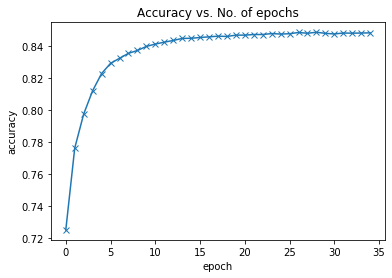

In [499]:
accuracies = [result['accuracy'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [521]:
class BinaryModel(nn.Module):
    def __init__(self, feature_count, hidden_size = 20):
        super(BinaryModel, self).__init__()
        self.layer1 = torch.nn.Linear(feature_count, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, 1)

    def forward(self, xb):
        out = self.layer1(xb)
        out = torch.sigmoid(self.layer2(out))
        return out

    def training_step(self, batch):
        features, labels = batch 
        out = torch.squeeze(self(features))
        loss = F.binary_cross_entropy(out, labels.float())
        return loss
    
    def validation_step(self, batch):
        features, labels = batch 
        out = torch.squeeze(self(features))
        loss = F.binary_cross_entropy(out, labels.float())
        pred = out.round()

        tp = (pred * labels).sum().to(torch.float32)
        fn = (labels * (1 - pred)).sum(dim=0).to(torch.float32)
        recall = tp / (tp + fn)
        return { 'loss': loss, 'recall': recall }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_recalls = [x['recall'] for x in outputs]
        epoch_recall = torch.stack(batch_recalls).mean()
        return { 'loss': epoch_loss.item(), 'recall': epoch_recall.item() }
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, recall: {:.4f}".format(epoch, result['loss'], result['recall']))

In [522]:
model = BinaryModel(feature_count)
history = fit(25, 0.005, model, train_dl, test_dl)

Epoch [0], loss: 0.6064, recall: 0.7571
Epoch [1], loss: 0.5514, recall: 0.7838
Epoch [2], loss: 0.5139, recall: 0.7963
Epoch [3], loss: 0.4865, recall: 0.8062
Epoch [4], loss: 0.4647, recall: 0.8146
Epoch [5], loss: 0.4465, recall: 0.8208
Epoch [6], loss: 0.4308, recall: 0.8259
Epoch [7], loss: 0.4173, recall: 0.8280
Epoch [8], loss: 0.4058, recall: 0.8284
Epoch [9], loss: 0.3958, recall: 0.8273
Epoch [10], loss: 0.3873, recall: 0.8252
Epoch [11], loss: 0.3800, recall: 0.8251
Epoch [12], loss: 0.3738, recall: 0.8273
Epoch [13], loss: 0.3684, recall: 0.8287
Epoch [14], loss: 0.3637, recall: 0.8288
Epoch [15], loss: 0.3597, recall: 0.8280
Epoch [16], loss: 0.3562, recall: 0.8272
Epoch [17], loss: 0.3532, recall: 0.8276
Epoch [18], loss: 0.3505, recall: 0.8277
Epoch [19], loss: 0.3481, recall: 0.8278
Epoch [20], loss: 0.3461, recall: 0.8274
Epoch [21], loss: 0.3443, recall: 0.8281
Epoch [22], loss: 0.3427, recall: 0.8279
Epoch [23], loss: 0.3412, recall: 0.8285
Epoch [24], loss: 0.3399, 

Text(0.5, 1.0, 'Recall vs. No. of epochs')

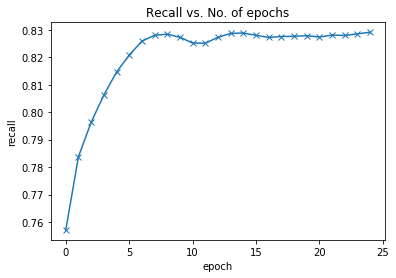

In [523]:
accuracies = [result['recall'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('recall')
plt.title('Recall vs. No. of epochs')